In [2]:
'''Data Handling & Linear Algebra'''
import numpy as np
import pandas as pd
import os

'''Visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns

'''Manipulating Data and Model Building'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

'''Implementation of Transfer Learning'''
from tensorflow.keras.applications import MobileNetV2

'''Image generation and preprocessing'''
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

'''Result and Performance Analysis'''
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

'''Ignoring Warnings'''
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os

# Set your directory path
DIR = 'fish_dataset/fish_dataset'

# Get the classes by filtering out '.ipynb_checkpoints'
classes = [i for i in os.listdir(DIR) if '.' not in i and i != '.ipynb_checkpoints']

print(classes)

['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


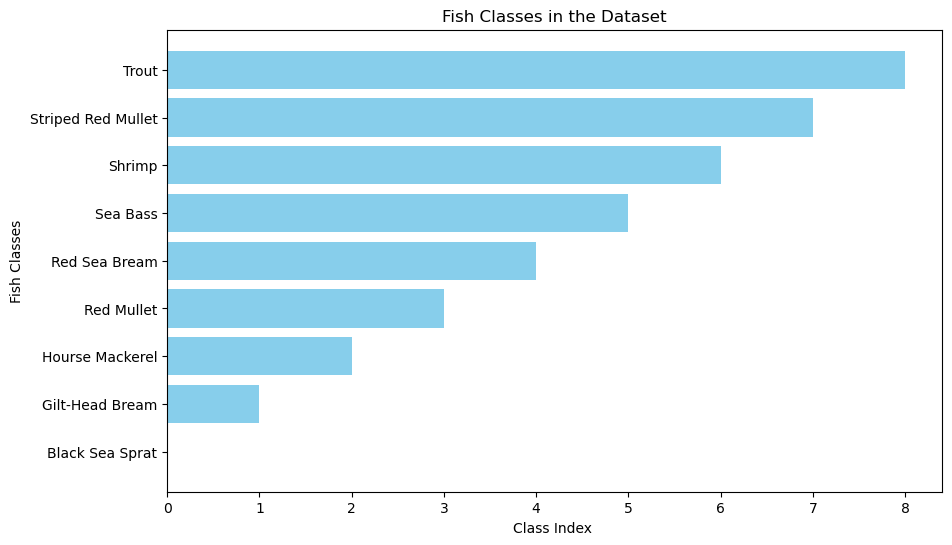

In [4]:
import os
import matplotlib.pyplot as plt

# Set your directory path
DIR = 'fish_dataset/fish_dataset'

# Get the classes by filtering out '.ipynb_checkpoints'
classes = [i for i in os.listdir(DIR) if '.' not in i and i != '.ipynb_checkpoints']

# Visualizing the classes as a bar plot
plt.figure(figsize=(10, 6))
plt.barh(classes, range(len(classes)), color='skyblue')
plt.title('Fish Classes in the Dataset')
plt.xlabel('Class Index ')
plt.ylabel('Fish Classes')
plt.show()

In [5]:
'''Since the GT images are of no use to us for the analysis, we will be separating them out of our directory'''

# Create a dataframe with a column which consists of all the filepaths (without GT) and its respective label as the other column

import pandas as pd

# Initialize lists for labels and file paths
label = []
path = []

# Walk through the directory and collect paths and labels for images
for dirname, _, filenames in os.walk(DIR):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':  # Only consider .png files
            # Skip directories containing 'GT' and '.ipynb_checkpoints'
            if 'GT' not in dirname and '.ipynb_checkpoints' not in dirname:
                label.append(os.path.split(dirname)[-1])  # Append the directory name (label)
                path.append(os.path.join(dirname, filename))  # Append the full path of the image

# Create a DataFrame to store the paths and labels
df = pd.DataFrame(columns=['path', 'label'])
df['path'] = path
df['label'] = label

# Display the label count to verify the data
print(df['label'].value_counts())
df['path'].dtype

label
Black Sea Sprat       1000
Gilt-Head Bream       1000
Hourse Mackerel       1000
Red Mullet            1000
Red Sea Bream         1000
Sea Bass              1000
Shrimp                1000
Striped Red Mullet    1000
Trout                 1000
Name: count, dtype: int64


dtype('O')

In [6]:
df.head()

path            label
0  fish_dataset/fish_dataset\Black Sea Sprat\Blac...  Black Sea Sprat
1  fish_dataset/fish_dataset\Black Sea Sprat\Blac...  Black Sea Sprat
2  fish_dataset/fish_dataset\Black Sea Sprat\Blac...  Black Sea Sprat
3  fish_dataset/fish_dataset\Black Sea Sprat\Blac...  Black Sea Sprat
4  fish_dataset/fish_dataset\Black Sea Sprat\Blac...  Black Sea Sprat

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [8]:
df['label'].value_counts()


label
Black Sea Sprat       1000
Gilt-Head Bream       1000
Hourse Mackerel       1000
Red Mullet            1000
Red Sea Bream         1000
Sea Bass              1000
Shrimp                1000
Striped Red Mullet    1000
Trout                 1000
Name: count, dtype: int64

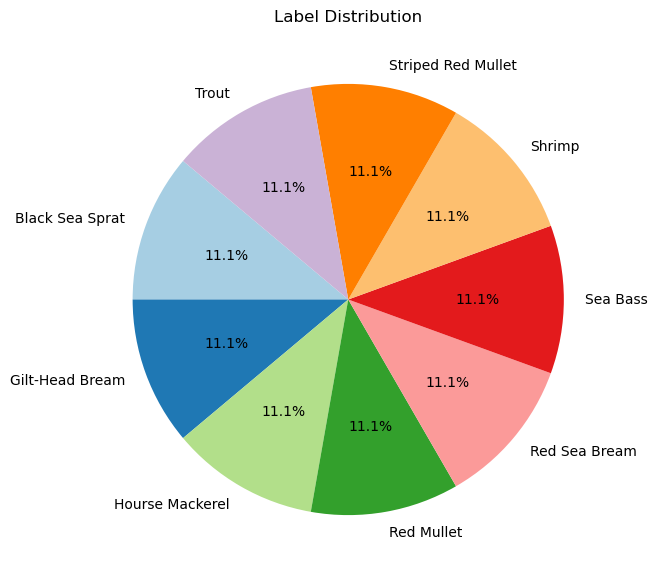

In [9]:
import matplotlib.pyplot as plt

label_counts = df['label'].value_counts()

plt.figure(figsize=(10, 7))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Label Distribution')
plt.show()


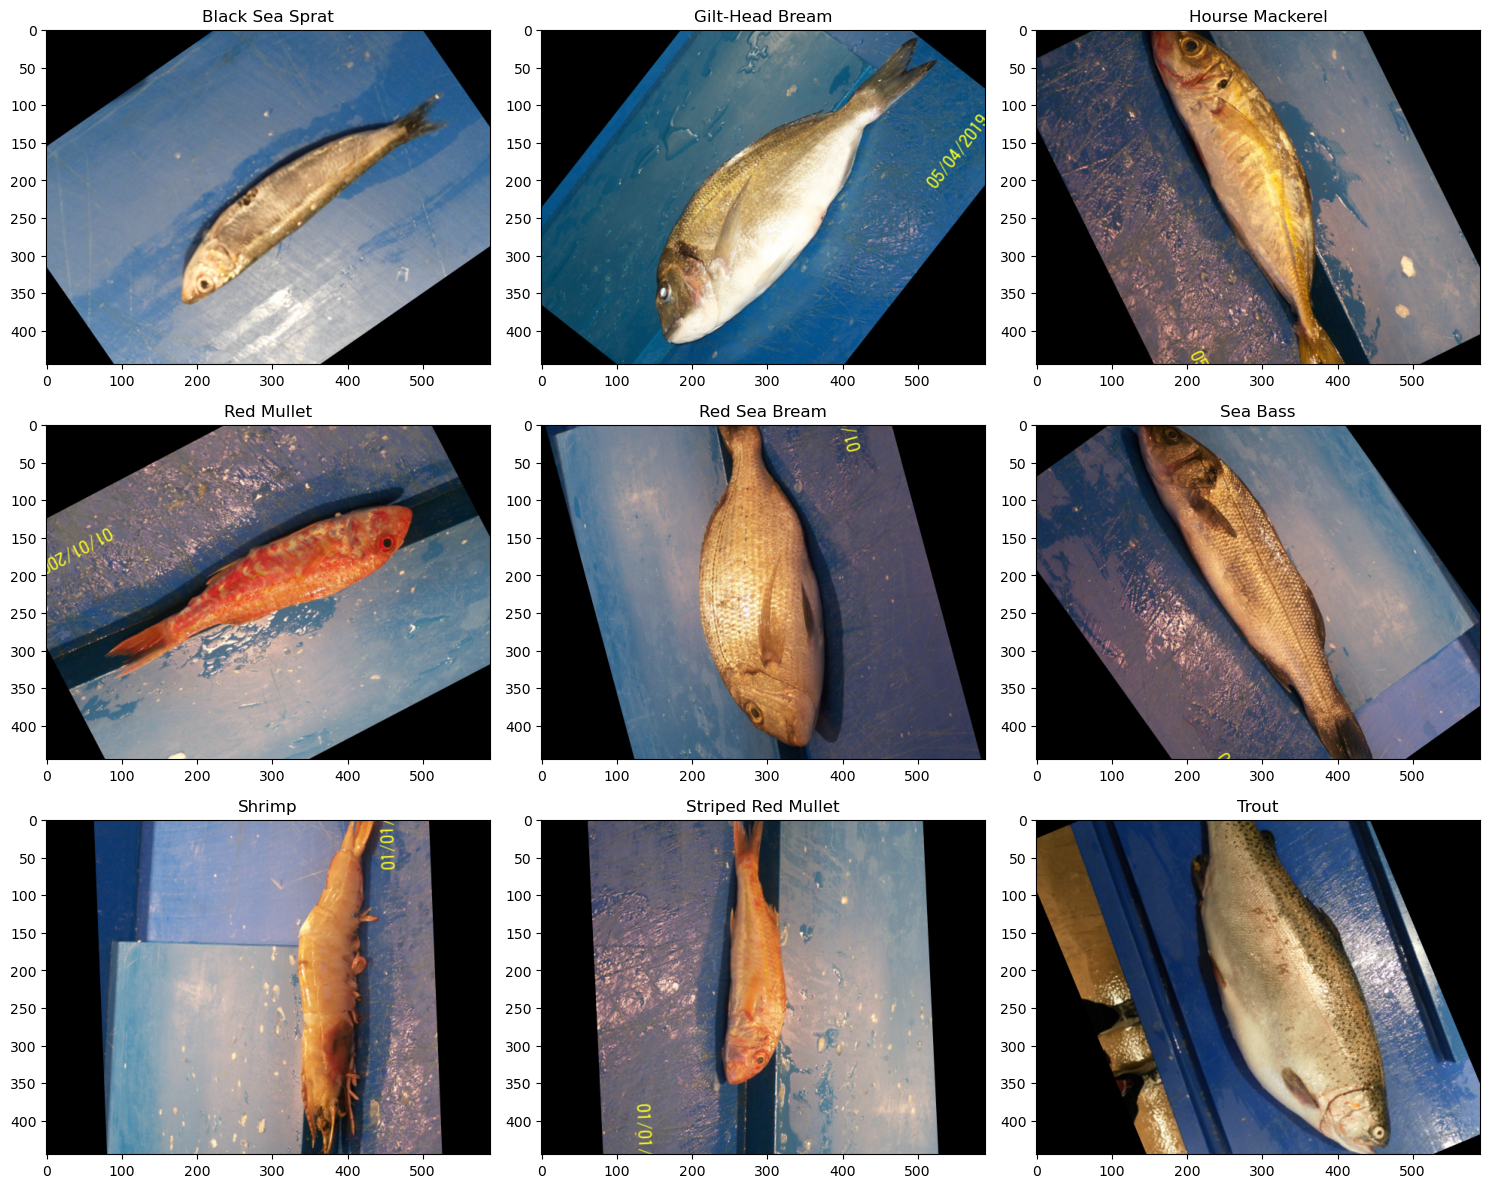

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df contains the data and 'label' is the column containing class labels
unique_labels = df['label'].unique()

# Determine the number of rows and columns for subplots based on the number of unique labels
rows = (len(unique_labels) // 3) + (len(unique_labels) % 3 > 0)  # Calculate number of rows
cols = 3  # Keep columns fixed at 3

# Create a new figure with dynamic size
plt.figure(figsize=(15, rows * 4))  # Adjust height based on the number of rows

# Plot each image for each label
for idx, unique_label in enumerate(unique_labels):
    plt.subplot(rows, cols, idx + 1)  # Adjust subplot index to match the dynamic grid size
    plt.imshow(plt.imread(df[df['label'] == unique_label].iloc[0, 0]))  # Display first image of the label
    plt.title(unique_label)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [11]:
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

In [12]:
# Checking the total number of images in the dataframe
print(f"Total images in train_df: {len(train_df)}")
print(f"Total images in test_df: {len(test_df)}")


Total images in train_df: 7200
Total images in test_df: 1800


In [13]:
#Checking the shape of the newly obtained data
print(train_df.shape)
print(test_df.shape)

(7200, 2)
(1800, 2)


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Trim test_df to only the first 1800 rows (if it's larger than 1800)
test_df = test_df.head(1800)

# Check the size of the trimmed test_df
print(f"Rows in trimmed test_df: {len(test_df)}")

# Create the ImageDataGenerators
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create train, validation, and test image generators
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

# Now, create the test image generator with the trimmed test_df
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,  # use the trimmed test_df here
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Check the number of test images processed
print(f"Test images: {len(test_images)}")


Rows in trimmed test_df: 1800
Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.
Test images: 57


In [15]:
# Checking the number of images in each generator
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")


Training images: 180
Validation images: 45
Test images: 57


In [16]:
print(f"Total training images: {len(train_images) * 32}")
print(f"Total validation images: {len(val_images) * 32}")
print(f"Total test images: {len(test_images) * 32}")


Total training images: 5760
Total validation images: 1440
Total test images: 1824


In [17]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)


{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [18]:
print(test_df.head())  # Check the first few rows to verify paths


                                                   path               label
7940  fish_dataset/fish_dataset\Striped Red Mullet\S...  Striped Red Mullet
1162  fish_dataset/fish_dataset\Gilt-Head Bream\Gilt...     Gilt-Head Bream
582   fish_dataset/fish_dataset\Black Sea Sprat\Blac...     Black Sea Sprat
4081  fish_dataset/fish_dataset\Red Sea Bream\Red Se...       Red Sea Bream
8412    fish_dataset/fish_dataset\Trout\Trout\00413.png               Trout


In [19]:
from PIL import Image
import os

invalid_images = []
for img_path in test_df['path']:
    try:
        img = Image.open(img_path)
        img.verify()  # Verifies if image is valid
    except Exception as e:
        invalid_images.append(img_path)

print(f"Invalid images: {invalid_images}")


Invalid images: []


In [20]:
test_subset = test_df.head(100)  # Select a smaller subset (100 rows)
test_images_subset = test_generator.flow_from_dataframe(
    dataframe=test_subset,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

print(f"Test images (subset): {len(test_images_subset)}")


Found 100 validated image filenames belonging to 9 classes.
Test images (subset): 4


In [21]:
print(test_df.info())  # Check for missing data


<class 'pandas.core.frame.DataFrame'>
Index: 1800 entries, 7940 to 1298
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    1800 non-null   object
 1   label   1800 non-null   object
dtypes: object(2)
memory usage: 42.2+ KB
None


In [22]:
invalid_paths = test_df[test_df['path'].isnull() | ~test_df['path'].str.contains(r'\.jpg$')]
print(f"Invalid paths in test_df: {invalid_paths}")



Invalid paths in test_df:                                                    path               label
7940  fish_dataset/fish_dataset\Striped Red Mullet\S...  Striped Red Mullet
1162  fish_dataset/fish_dataset\Gilt-Head Bream\Gilt...     Gilt-Head Bream
582   fish_dataset/fish_dataset\Black Sea Sprat\Blac...     Black Sea Sprat
4081  fish_dataset/fish_dataset\Red Sea Bream\Red Se...       Red Sea Bream
8412    fish_dataset/fish_dataset\Trout\Trout\00413.png               Trout
...                                                 ...                 ...
3063  fish_dataset/fish_dataset\Red Mullet\Red Mulle...          Red Mullet
6925  fish_dataset/fish_dataset\Shrimp\Shrimp\00926.png              Shrimp
6521  fish_dataset/fish_dataset\Shrimp\Shrimp\00522.png              Shrimp
3002  fish_dataset/fish_dataset\Red Mullet\Red Mulle...          Red Mullet
1298  fish_dataset/fish_dataset\Gilt-Head Bream\Gilt...     Gilt-Head Bream

[1800 rows x 2 columns]


In [23]:
test_df['path'] = test_df['path'].str.replace(r'\\', '/', regex=True)


In [24]:
print(test_df.head())


                                                   path               label
7940  fish_dataset/fish_dataset/Striped Red Mullet/S...  Striped Red Mullet
1162  fish_dataset/fish_dataset/Gilt-Head Bream/Gilt...     Gilt-Head Bream
582   fish_dataset/fish_dataset/Black Sea Sprat/Blac...     Black Sea Sprat
4081  fish_dataset/fish_dataset/Red Sea Bream/Red Se...       Red Sea Bream
8412    fish_dataset/fish_dataset/Trout/Trout/00413.png               Trout


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


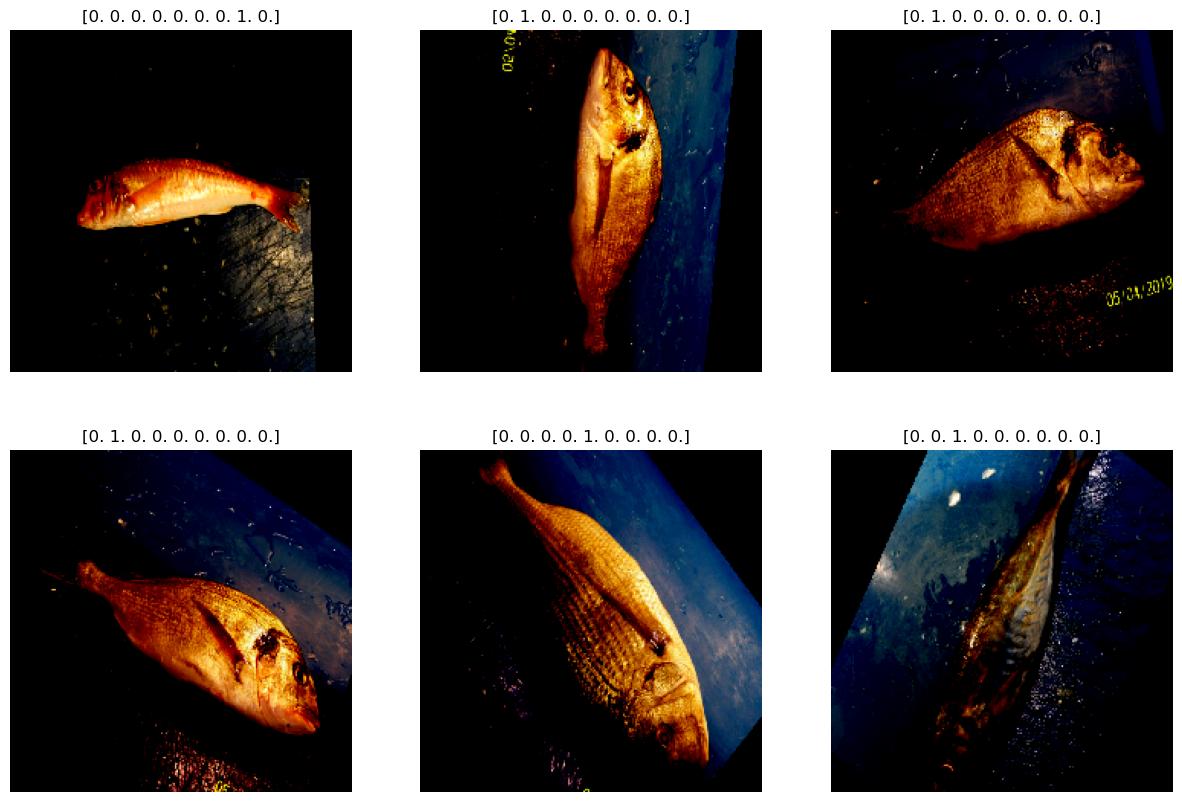

In [25]:
#Plotting images after pre-processing
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the layout for 6 images
ax = ax.ravel()  # Flatten the axes for easy iteration

# Loop through and display 6 images
for j in range(6):
    img, label = next(test_images)  # Get next image and label batch
    ax[j].imshow(img[0])  # Display the first image in the batch
    ax[j].set_title(label[0])  # Display the first label in the batch
    ax[j].axis('off')  # Hide axes

plt.show()


In [26]:
#Importing our pretrained model : MobileNetV2

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [27]:
import tensorflow as tf

# Define the model inputs and layers
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)  # Adjust '9' to the number of classes

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Save the model
model.save('model.keras')

# Print the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_images,  # Training dataset
    validation_data=val_images,  # Validation dataset
    epochs=5 # Number of epochs
)





Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,439,625 (9.31 MB)

 Trainable params: 181,641 (709.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.8617 - loss: 0.4890 - val_accuracy: 0.9972 - val_loss: 0.0136
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 173s 962ms/step - accuracy: 0.9974 - loss: 0.0107 - val_accuracy: 0.9986 - val_loss: 0.0067
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 167s 927ms/step - accuracy: 0.9987 - loss: 0.0055 - val_accuracy: 0.9944 - val_loss: 0.0187
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 167s 929ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9979 - val_loss: 0.0062
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 167s 930ms/step - accuracy: 1.0000 - loss: 7.4276e-04 - val_accuracy: 0.9993 - val_loss: 0.0048


In [28]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.00267
Test Accuracy: 99.94%


Test Loss: 0.00267
Test Accuracy: 99.94%


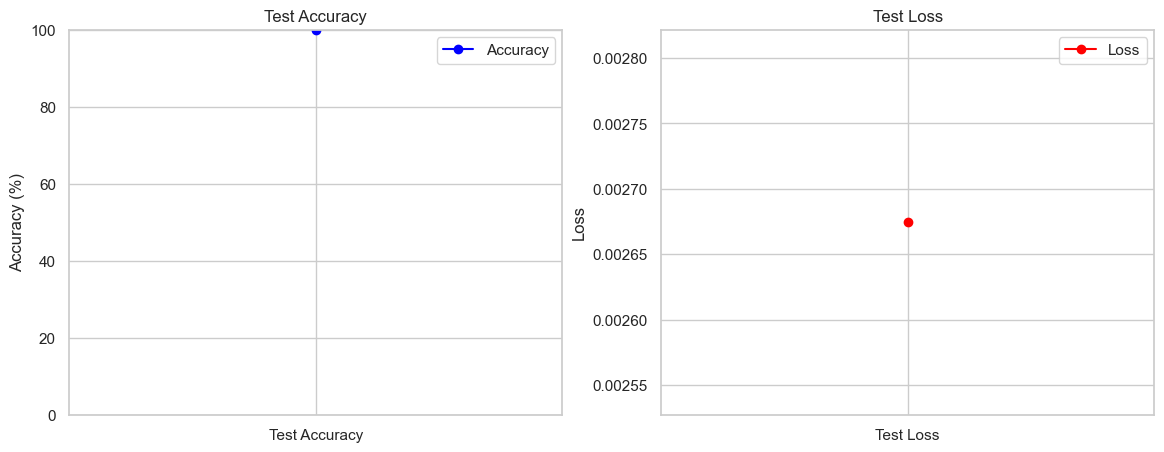

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Evaluate the model on the test set
results = model.evaluate(test_images, verbose=0)

# Print the results
test_loss, test_accuracy = results
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

# Plot Test Accuracy and Loss
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot test accuracy as a line plot
ax[0].plot(['Test Accuracy'], [test_accuracy * 100], marker='o', color='blue', label='Accuracy')
ax[0].set_title('Test Accuracy')
ax[0].set_ylim([0, 100])
ax[0].set_ylabel('Accuracy (%)')
ax[0].legend()

# Plot test loss as a line plot
ax[1].plot(['Test Loss'], [test_loss], marker='o', color='red', label='Loss')
ax[1].set_title('Test Loss')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()


In [30]:
# Get predictions for the test images
predictions = model.predict(test_images)

# Convert predictions to class labels
predicted_classes = predictions.argmax(axis=-1)  # Get the index of the class with the highest probability

# If you want to see the predicted classes
print(predicted_classes)


57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 764ms/step
[7 1 0 ... 6 3 1]


In [31]:
# Map class indices back to class labels (e.g., fish species names)
class_labels = test_images.class_indices  # Get class indices from the generator
class_labels = {v: k for k, v in class_labels.items()}  # Invert the dictionary

# Map predictions to class labels
predicted_class_labels = [class_labels[idx] for idx in predicted_classes]

# Optionally, display the predictions alongside the image paths
for idx, path in enumerate(test_df['path']):
    print(f"Image: {path} -> Predicted: {predicted_class_labels[idx]}")


Image: fish_dataset/fish_dataset/Striped Red Mullet/Striped Red Mullet/00941.png -> Predicted: Striped Red Mullet
Image: fish_dataset/fish_dataset/Gilt-Head Bream/Gilt-Head Bream/00163.png -> Predicted: Gilt-Head Bream
Image: fish_dataset/fish_dataset/Black Sea Sprat/Black Sea Sprat/00583.png -> Predicted: Black Sea Sprat
Image: fish_dataset/fish_dataset/Red Sea Bream/Red Sea Bream/00082.png -> Predicted: Red Sea Bream
Image: fish_dataset/fish_dataset/Trout/Trout/00413.png -> Predicted: Trout
Image: fish_dataset/fish_dataset/Trout/Trout/00731.png -> Predicted: Trout
Image: fish_dataset/fish_dataset/Sea Bass/Sea Bass/00937.png -> Predicted: Sea Bass
Image: fish_dataset/fish_dataset/Trout/Trout/00284.png -> Predicted: Trout
Image: fish_dataset/fish_dataset/Red Mullet/Red Mullet/00707.png -> Predicted: Red Mullet
Image: fish_dataset/fish_dataset/Red Sea Bream/Red Sea Bream/00072.png -> Predicted: Red Sea Bream
Image: fish_dataset/fish_dataset/Red Mullet/Red Mullet/00754.png -> Predicted: 

In [35]:
import pandas as pd

# Save predictions to a DataFrame
predictions_df = pd.DataFrame({
    'Image Path': test_df['path'],
    'True Label': test_df['label'],
    'Predicted Label': predicted_class_labels,
    'Prediction Confidence': predictions.max(axis=-1)
})

# Save the DataFrame to a CSV file
predictions_df.to_csv('prediction.csv', index=False)


In [37]:
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 739ms/step


In [38]:
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [39]:
# Visualize the pred_df
pred_df=pred_df.reset_index(drop=True)
pred_df.head(10)

path               label  \
0  fish_dataset/fish_dataset/Striped Red Mullet/S...  Striped Red Mullet   
1  fish_dataset/fish_dataset/Gilt-Head Bream/Gilt...     Gilt-Head Bream   
2  fish_dataset/fish_dataset/Black Sea Sprat/Blac...     Black Sea Sprat   
3  fish_dataset/fish_dataset/Red Sea Bream/Red Se...       Red Sea Bream   
4    fish_dataset/fish_dataset/Trout/Trout/00413.png               Trout   
5    fish_dataset/fish_dataset/Trout/Trout/00731.png               Trout   
6  fish_dataset/fish_dataset/Sea Bass/Sea Bass/00...            Sea Bass   
7    fish_dataset/fish_dataset/Trout/Trout/00284.png               Trout   
8  fish_dataset/fish_dataset/Red Mullet/Red Mulle...          Red Mullet   
9  fish_dataset/fish_dataset/Red Sea Bream/Red Se...       Red Sea Bream   

                 pred  
0  Striped Red Mullet  
1     Gilt-Head Bream  
2     Black Sea Sprat  
3       Red Sea Bream  
4               Trout  
5               Trout  
6            Sea Bass  
7               Trout  
8          Red Mullet  
9       Red Sea Bream

In [40]:
# Incorrect prediction
pred_df[pred_df['label']!=pred_df['pred']]


path     label  \
1380  fish_dataset/fish_dataset/Sea Bass/Sea Bass/00...  Sea Bass   

               pred  
1380  Red Sea Bream

In [42]:
pred_df.path[1380]

'fish_dataset/fish_dataset/Sea Bass/Sea Bass/00816.png'

In [44]:
pred_df.path[1380]

'fish_dataset/fish_dataset/Sea Bass/Sea Bass/00816.png'

Image Path: fish_dataset/fish_dataset/Sea Bass/Sea Bass/00816.png
Unexpected path structure at index 1380


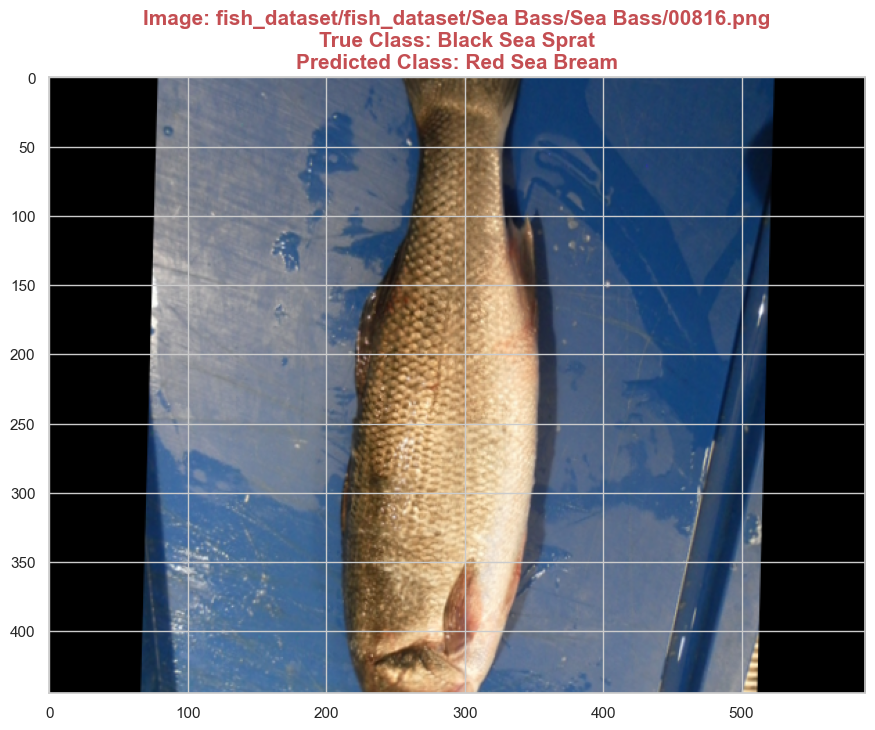

In [46]:
# Let's first check the value of the path at index 1380
image_path = pred_df.path[1380]
print("Image Path:", image_path)

# Split the path based on the system separator
path_parts = image_path.split('\\')  # Or use os.path.sep for a more flexible solution

# Ensure that the path has enough parts to extract
if len(path_parts) > 1:
    true_class = path_parts[1]  # Assuming fish name is the second part of the path
else:
    print(f"Unexpected path structure at index {1380}")

# Extract image name (last part of the path)
image_name = path_parts[-1]

# Get predicted class
predicted_class = pred_df.pred[1380]

# Display the image
plt.figure(figsize=(15, 8))
plt.imshow(plt.imread(image_path))

# Set title with corrected labels
plt.title(
    f'Image: {image_name}\nTrue Class: {true_class}\nPredicted Class: {predicted_class}',
    color='r',
    weight='bold',
    fontsize=15
)

# Show the plot
plt.show()


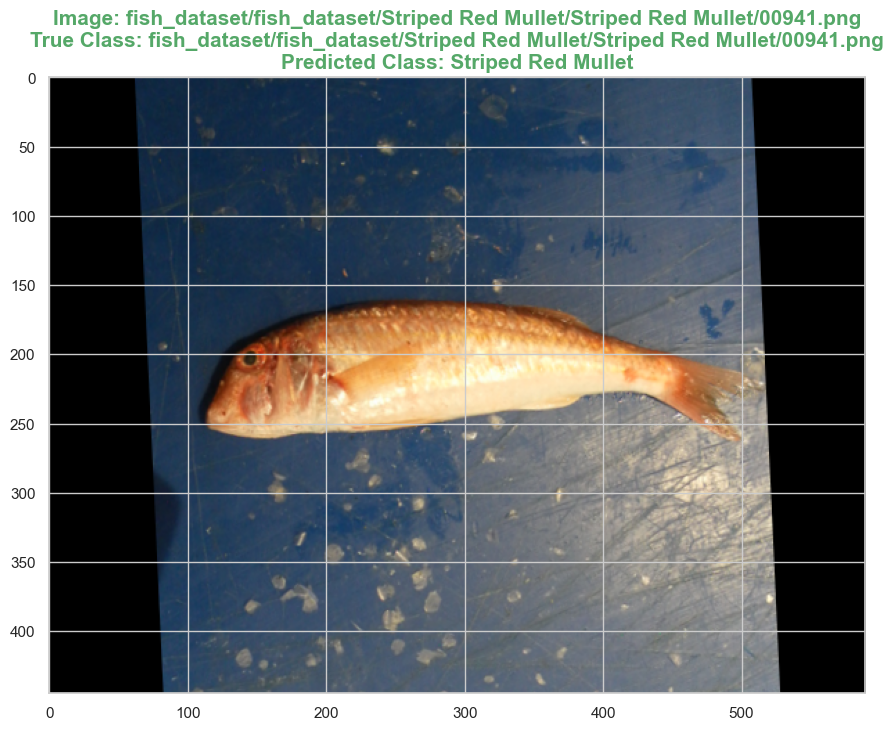

In [48]:
# Get the first valid row with correct prediction
valid_index = 0  # Use the first row in correct_df
image_path = correct_df.iloc[valid_index].path

# Display the image
plt.figure(figsize=(15, 8))
plt.imshow(plt.imread(image_path))

# Extract the path parts
path_parts = image_path.split('\\')  # Adjust for your OS path separator

# Check the structure of the path
if len(path_parts) > 1:
    true_class = path_parts[1]  # Assuming the second part is the class
else:
    true_class = path_parts[0]  # If only one part, assume the class is in the first part

# Extract image name and predicted class
image_name = path_parts[-1]  # Image file name
predicted_class = correct_df.iloc[valid_index].pred

# Set title with labels
plt.title(
    f'Image: {image_name}\nTrue Class: {true_class}\nPredicted Class: {predicted_class}',
    color='g',  # Green for correct prediction
    weight='bold',
    fontsize=15
)

# Show the plot
plt.show()


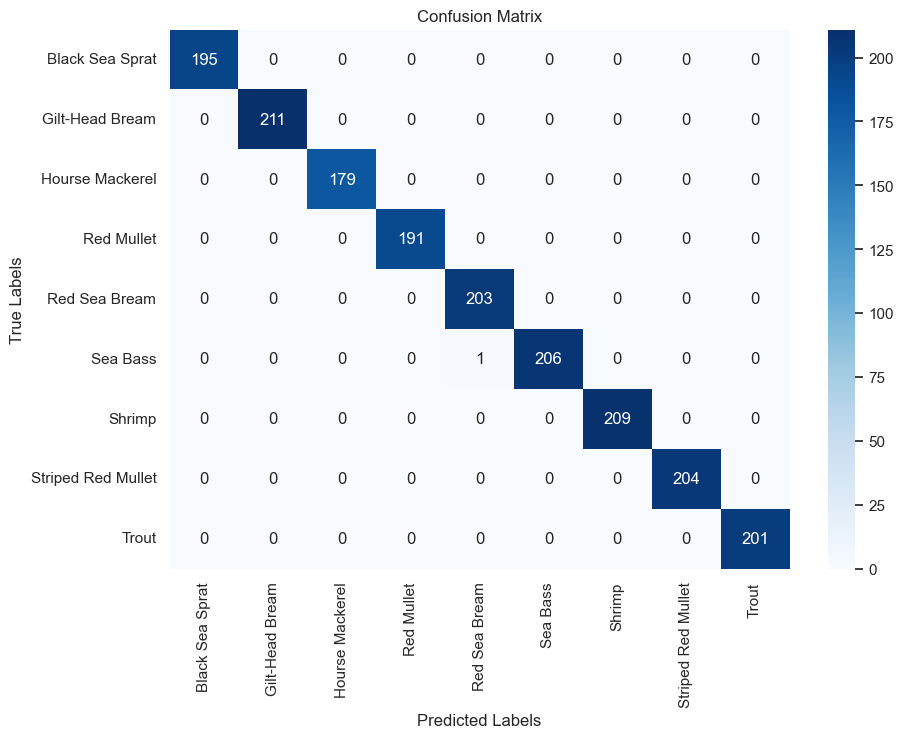

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels from the test generator
true_labels = test_images.classes

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Visualize confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_images.class_indices.keys(), yticklabels=test_images.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
